# 1 项目摘要
本项目的目的主要是对糖尿病进行预测。主要依托某医院体检数据（处理后），首先进行了数据的描述性统计。后续针对数据的特征进行特征选择（三种方法），选出与性别、年龄等预测相关度最高的几个属性值。此后选择Logistic回归、支持向量机和XGBoost三种机器学习模型，将选择好的属性值输入对糖尿病风险预警模型进行训练，并运用F1-Score、AUC值等方法进行预警模型的分析评价。最后进行了模型的调参（GridSearch），选择了最优参数输入模型，对比后发现模型性能得到了一定提升。

# 2 数据导入、处理与描述性统计
## 2.1导入与映射处理

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

import os
os.chdir(r'../dia-1000')
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
# xls1=pd.ExcelFile(r'dia.xls')
# csv1=pd.read_csv(r'dia.csv')
# dataConcat1=pd.read_excel(xls1)
dataConcat1=pd.read_csv(r'dia.csv')
dataConcat1.head()

,卡号,性别,年龄,高密度脂蛋白胆固醇,低密度脂蛋白胆固醇,极低密度脂蛋白胆固醇,甘油三酯,总胆固醇,脉搏,舒张压,高血压史,尿素氮,尿酸,肌酐,体重检查结果,是否糖尿病
0,18054421,0,38,1.25,2.99,1.07,0.64,5.31,83,83,0,4.99,243.3,50,1,0
1,18054422,0,31,1.15,1.99,0.84,0.50,3.98,85,63,0,4.72,391.0,47,1,0
2,18054423,0,27,1.29,2.21,0.69,0.60,4.19,73,61,0,5.87,325.7,51,1,0
3,18054424,0,33,0.93,2.01,0.66,0.84,3.60,83,60,0,2.40,203.2,40,2,0
4,18054425,0,36,1.17,2.83,0.83,0.73,4.83,85,67,0,4.09,236.8,43,0,0


In [2]:
dataConcat1.shape

(1006, 16)

In [7]:
#为了后续更好地将数据输入机器学习模型，有必要将某些数据列进行分桶
#%matplotlib notebook #交互式图表
age=dataConcat1['年龄']
age_binary=pd.cut(age,[0,30,45,60,100],labels=[0,1,2,3],right=False)
dataConcat1['年龄_cut']=age_binary
dataConcat1['年龄_cut']=dataConcat1['年龄_cut'].astype("float")

pulse=dataConcat1['脉搏']
pulse_binary=pd.cut(pulse,[0,60,99,200],labels=[0,1,2],right=False)
#right：bool型参数，默认为True，表示是否包含区间右部。比如如果bins=[1,2,3]，right=True，则区间为(1,2]，(2,3]；right=False，则区间为(1,2),(2,3)
dataConcat1['脉搏']=pulse_binary
dataConcat1['脉搏']=dataConcat1['脉搏'].astype("float")

pressure=dataConcat1['舒张压']
pressure_binary=pd.cut(pressure,[0,60,89,200],labels=[0,1,2],right=False)
dataConcat1['舒张压']=pressure_binary
dataConcat1['舒张压']=dataConcat1['舒张压'].astype("float")

dataConcat1.head()

,卡号,性别,年龄,高密度脂蛋白胆固醇,低密度脂蛋白胆固醇,极低密度脂蛋白胆固醇,甘油三酯,总胆固醇,脉搏,舒张压,高血压史,尿素氮,尿酸,肌酐,体重检查结果,是否糖尿病,年龄_cut
0,18054421,0,38,1.25,2.99,1.07,0.64,5.31,1.0,1.0,0,4.99,243.3,50,1,0,1.0
1,18054422,0,31,1.15,1.99,0.84,0.50,3.98,1.0,1.0,0,4.72,391.0,47,1,0,1.0
2,18054423,0,27,1.29,2.21,0.69,0.60,4.19,1.0,1.0,0,5.87,325.7,51,1,0,0.0
3,18054424,0,33,0.93,2.01,0.66,0.84,3.60,1.0,1.0,0,2.40,203.2,40,2,0,1.0
4,18054425,0,36,1.17,2.83,0.83,0.73,4.83,1.0,1.0,0,4.09,236.8,43,0,0,1.0


## 2.2 描述性统计

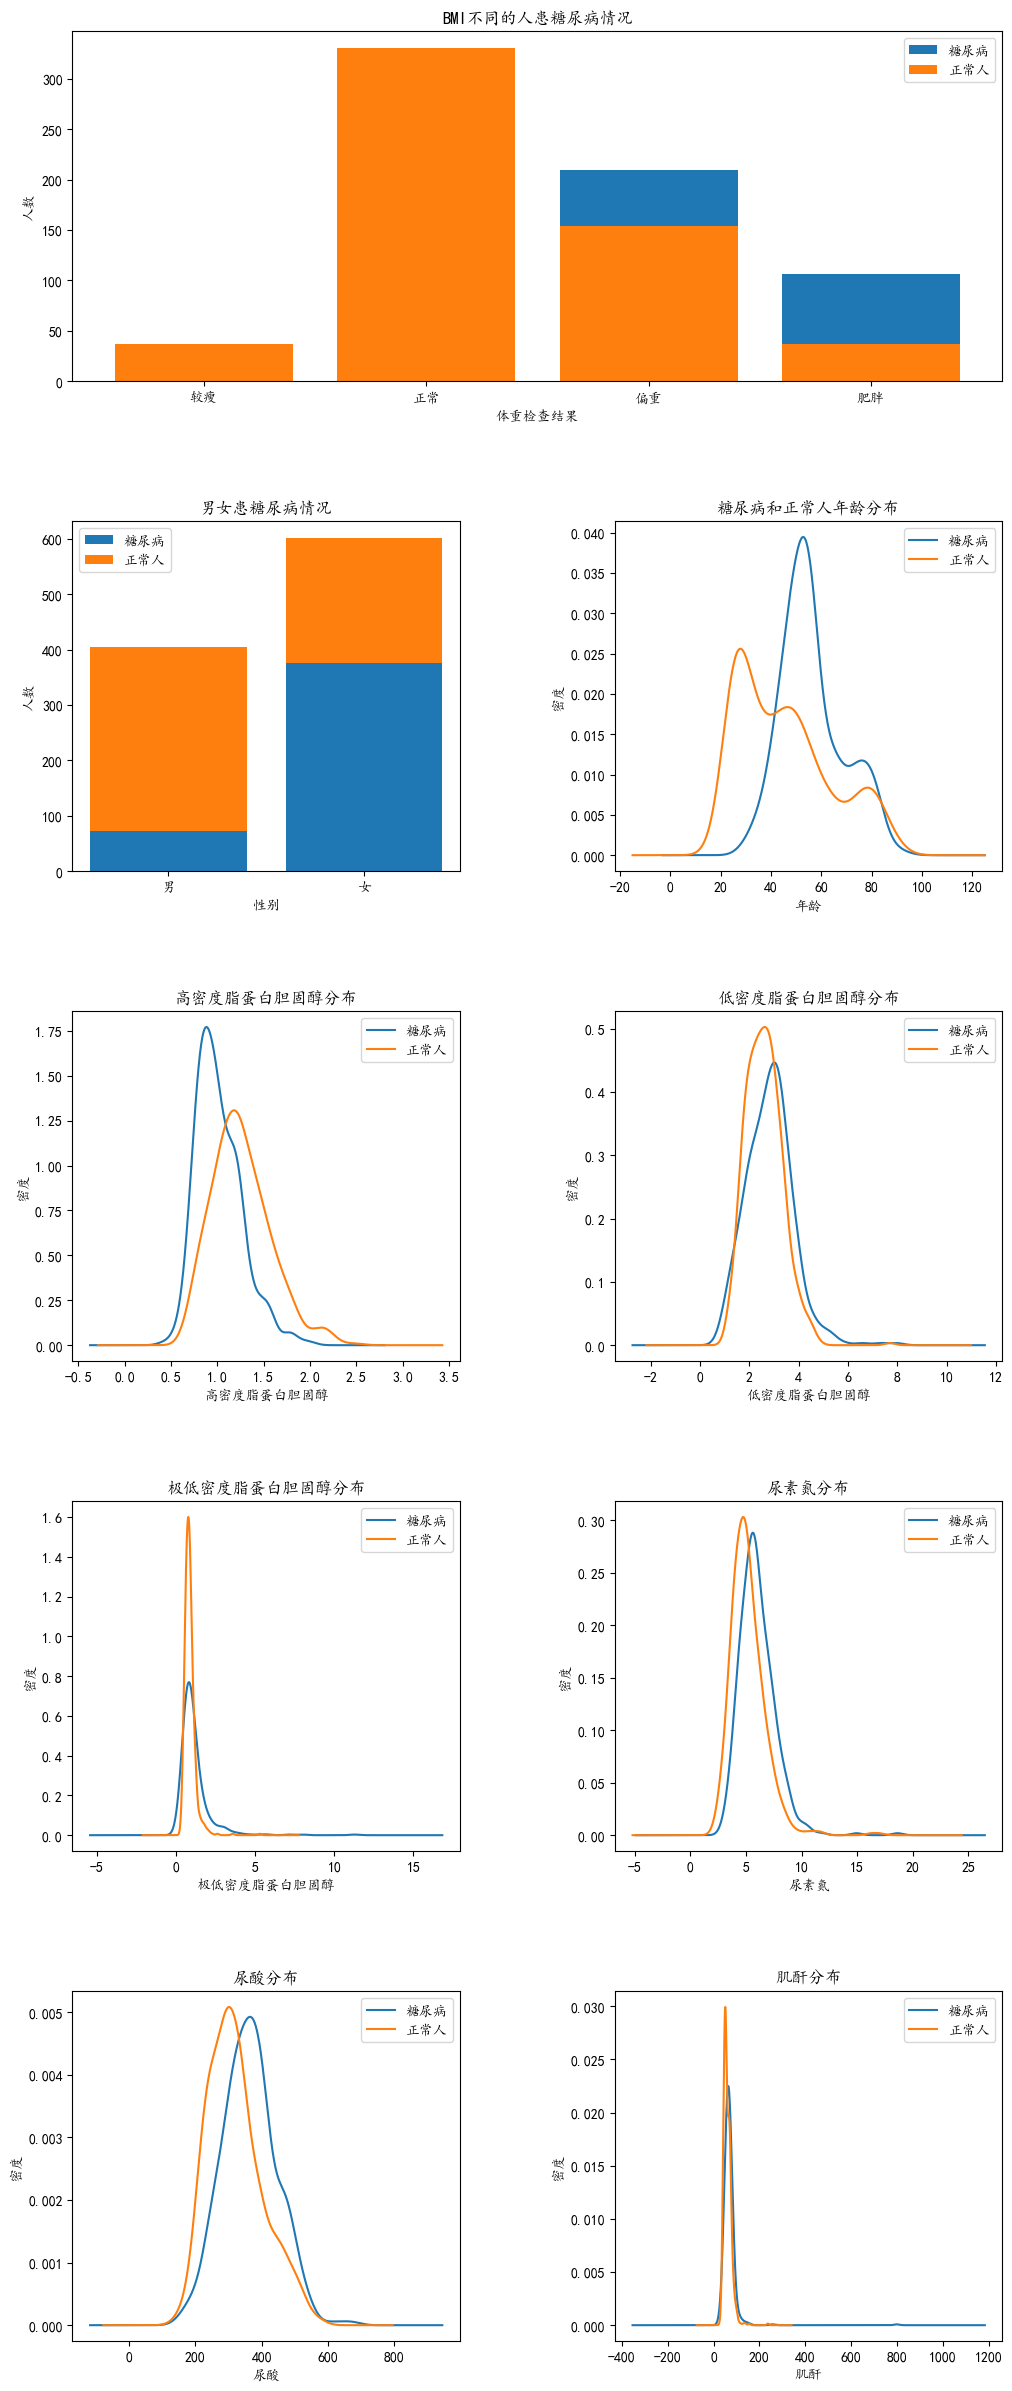

In [9]:
fig=plt.figure(figsize=(12,30))

plt.subplots_adjust(wspace = 0.4,hspace = 0.4 )  #调整子图内部间距
a2=plt.subplot2grid((5,2),(0,0),colspan=2) 
diabetes_0_1 = dataConcat1.体重检查结果[dataConcat1.是否糖尿病 == 0].value_counts()
diabetes_1_1 = dataConcat1.体重检查结果[dataConcat1.是否糖尿病 == 1].value_counts()
df1=pd.DataFrame({'糖尿病患者':diabetes_1_1,'正常人':diabetes_0_1})
weight_map={0:'较瘦',1:'正常',2:'偏重',3:'肥胖'}
df1.index = df1.index.map(weight_map)
a2.bar(['较瘦','正常','偏重','肥胖'],df1['糖尿病患者'])
a2.bar(['较瘦','正常','偏重','肥胖'],df1['正常人'])
plt.title(u"BMI不同的人患糖尿病情况")
plt.xlabel(u"体重检查结果") 
plt.ylabel(u"人数")
plt.legend((u'糖尿病', u'正常人'),loc='best')

a1=plt.subplot2grid((5,2),(1,0)) 
diabetes_0 = dataConcat1.性别[dataConcat1.是否糖尿病 == 0].value_counts()
diabetes_1 = dataConcat1.性别[dataConcat1.是否糖尿病 == 1].value_counts()
df=pd.DataFrame({'糖尿病患者':diabetes_1,'正常人':diabetes_0})
sex_map={1:'男',0:'女'}
df.index = df.index.map(sex_map)
a1.bar(['男','女'],df['糖尿病患者'])
a1.bar(['男','女'],df['正常人'],bottom=list(df.loc[:,'糖尿病患者']))
plt.title(u"男女患糖尿病情况")
plt.xlabel(u"性别") 
plt.ylabel(u"人数") 
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(1,1)) 
dataConcat1.年龄[dataConcat1.是否糖尿病 == 1].plot(kind='kde')   
dataConcat1.年龄[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"年龄")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"糖尿病和正常人年龄分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(2,0)) 
dataConcat1.高密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.高密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"高密度脂蛋白胆固醇")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"高密度脂蛋白胆固醇分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(2,1)) 
dataConcat1.低密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.低密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"低密度脂蛋白胆固醇")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"低密度脂蛋白胆固醇分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(3,0)) 
dataConcat1.极低密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.极低密度脂蛋白胆固醇[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"极低密度脂蛋白胆固醇")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"极低密度脂蛋白胆固醇分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(3,1)) 
dataConcat1.尿素氮[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.尿素氮[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"尿素氮")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"尿素氮分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(4,0)) 
dataConcat1.尿酸[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.尿酸[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"尿酸")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"尿酸分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.subplot2grid((5,2),(4,1)) 
dataConcat1.肌酐[dataConcat1.是否糖尿病 == 1].plot(kind='kde') 
dataConcat1.肌酐[dataConcat1.是否糖尿病 == 0].plot(kind='kde')
plt.xlabel(u"肌酐")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"肌酐分布")
plt.legend((u'糖尿病', u'正常人'),loc='best')

plt.savefig('descriptive_statistics.jpg')


从基本的描述性统计中，我们可以发现糖尿病人与正常人之间的的一些差异，比如体重指数较高，高密度脂蛋白胆固醇较低，尿素氮和尿酸较高等

# 3 特征选择
## 3.1 通过相关性进行筛选
无论算法是回归（预测数字）还是分类（预测类别），特征都必须与目标相关。 如果一个特征没有表现出相关性，它就是一个主要的消除目标。 可以分别测试数值和分类特征的相关性。

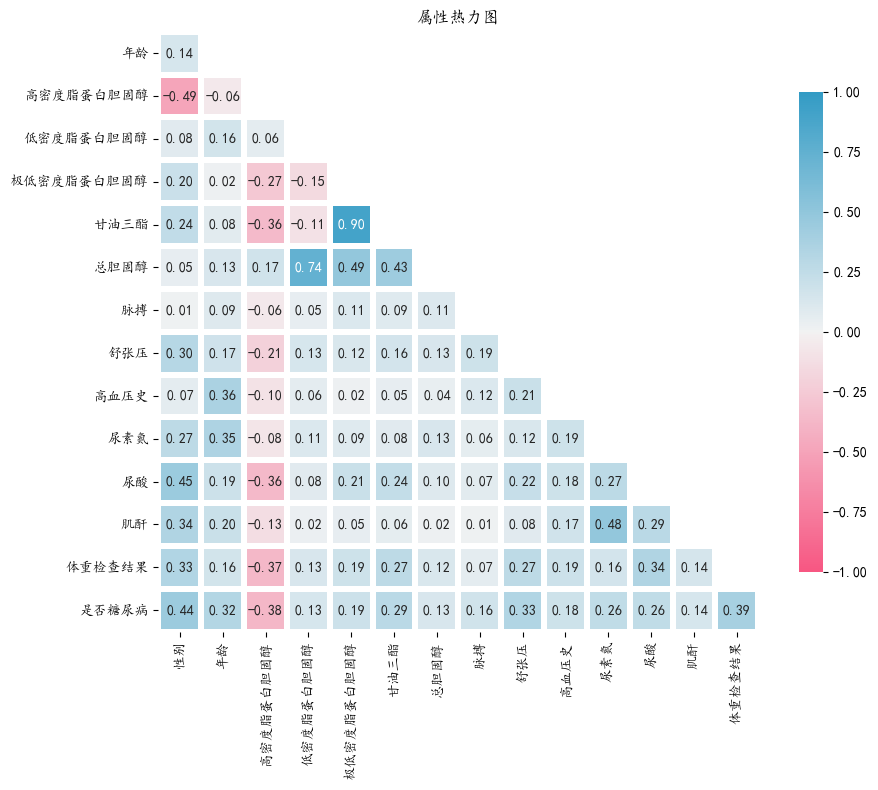

In [11]:
#属性热力如果模型仅用于预测，则只要拟合程度好，可不处理多重共线性问题，存在多重共线性的模型用于预测时，往往不影响预测结果。图
plt.figure(figsize=(10,8))
df_cor=dataConcat1.iloc[:,1:-1]
df_cor.corr()
data_cor=df_cor.corr()
mask = np.triu(np.ones_like(data_cor, dtype=np.bool_))
# adjust mask and df
mask = mask[1:, :-1]
corr = data_cor.iloc[1:, :-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f", cmap=cmap,linewidth=3,
               vmin=-1, vmax=1, cbar_kws={"shrink": .8},square=True)
plt.title('属性热力图')
plt.tight_layout()#调整布局防止显示不全
plt.savefig('Attribute_dependent_heat_map.jpg')

## 3.2 多重共线性
&emsp;&emsp;当任何两个特征之间存在相关性时，就会出现多重共线性。 在机器学习中，期望每个特征都应该独立于其他特征，即它们之间没有共线性。
3.1中的Heatmap 是检查和寻找相关特征的最简单方法。
&emsp;&emsp;此外方差膨胀因子 (VIF) 是衡量多重共线性的另一种方法。 它被测量为整体模型方差与每个独立特征的方差的比率。计算公式如下：
$$VIF=\frac{1}{1-R_{i}^{2}}$$
&emsp;&emsp;其中，$R_{i}$为自变量对其余自变量作回归分析的负相关系数。
一个特征的高VIF表明它与一个或多个其他特征相关。 根据经验，VIF大于10，则代表变量有较严重的多重共线性。<br>
&emsp;&emsp;注意：如果模型仅用于预测，则只要拟合程度好，可不处理多重共线性问题，存在多重共线性的模型用于预测时，往往不影响预测结果。

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
feature_names = ['性别', '年龄_cut', '低密度脂蛋白胆固醇','高密度脂蛋白胆固醇',
                 '极低密度脂蛋白胆固醇','甘油三酯', '总胆固醇', '脉搏', '舒张压','高血压史','尿素氮','尿酸','肌酐','体重检查结果']
X=dataConcat1[feature_names]
y=dataConcat1.是否糖尿病
# 计算 VIF 
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns) 
# 展示VIF结果
index = X.columns.tolist() 
vif_df = pd.DataFrame(vif, index = index, columns = ['vif']).sort_values(by = 'vif', ascending=False) 
vif_df

,vif
总胆固醇,5303.841628
低密度脂蛋白胆固醇,1751.020663
极低密度脂蛋白胆固醇,331.897977
高密度脂蛋白胆固醇,321.809192
尿酸,20.352819
尿素氮,17.915721
脉搏,10.972505
甘油三酯,9.826460
肌酐,8.277058
体重检查结果,6.953942


## 3.3 RFE（递归特征消除法）


&emsp;&emsp;使用RFE进行特征选择：RFE是常见的特征选择方法，也叫递归特征消除。它的工作原理是递归删除特征，并在剩余的特征上构建模型。它使用模型准确率来判断哪些特征（或特征组合）对预测结果贡献较大。<br>
&emsp;&emsp;2000 年，Weston G.等人在对研究对癌症进行分类时，提出了SVM-RFE特征选择算法并应用到癌症分类。作为一种经典的包裹式特征选择方法，SVM-RFE特征选择算法也曾被广泛用于医学预测问题的特征选择，并取得良好的选择效果。SVM-RFE 算法使用SVM算法作为基模型，对数据集中的特征进行排序，然后使用递归特征消除算法将排序靠后特征消除，以此实现特征选择。SVM的介绍与推导在2.1.2节有所提及，下面对该算法的实现步骤进行总结。其算法的实现步骤如下：<br>
&emsp;&emsp;①输入原始特征集Q =（Q1，Q2，...，Qm）;<br>
&emsp;&emsp;②初始化目标特征集$Q^{*}$= q;<br>
&emsp;&emsp;③根据Q对支持向量机进行训练，得到所有特征的权重，将其进行平方处理后并按照降序对特征进行排名;<br>
&emsp;&emsp;④不断对步骤迭代，直到留下最后一个属性特征，更新$Q^{*}$；<br>
&emsp;&emsp;⑤若得到的目标特征集Q*模型的拟合程度不再继续增加，MSE不再继续降低，则算法结束，所得的n个特征即为所选择的n个特征，否则，转③。


In [13]:
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数
min_max_scaler1 = preprocessing.MinMaxScaler()
X_train_minmax1 = min_max_scaler1.fit_transform(dataConcat1[feature_names])#特征归一化处理
svc = SVC(kernel="linear")
selector=RFE(estimator=svc, n_features_to_select=8)
Xt=selector.fit_transform(X_train_minmax1,dataConcat1.是否糖尿病)
print("N_features %s" % selector.n_features_) # 保留的特征数
print("Support is %s" % selector.support_) # 是否保留
print("Ranking %s" % selector.ranking_) # 重要程度排名
for i in zip(selector.ranking_,feature_names,selector.support_):
    print(i)

N_features 8
Support is [ True  True False  True False  True False  True False False  True False
  True  True]
Ranking [1 1 3 1 6 1 5 1 2 7 1 4 1 1]
(1, '性别', True)
(1, '年龄_cut', True)
(3, '低密度脂蛋白胆固醇', False)
(1, '高密度脂蛋白胆固醇', True)
(6, '极低密度脂蛋白胆固醇', False)
(1, '甘油三酯', True)
(5, '总胆固醇', False)
(1, '脉搏', True)
(2, '舒张压', False)
(7, '高血压史', False)
(1, '尿素氮', True)
(4, '尿酸', False)
(1, '肌酐', True)
(1, '体重检查结果', True)


## 3.4 正则化
&emsp;&emsp;正则化减少了过拟合。 如果你有太多的特征，正则化控制它们的效果，或者通过缩小特征系数（称为 L2 正则化）或将一些特征系数设置为零（称为 L1 正则化）。一些模型具有内置的 L1/L2 正则化作为超参数来惩罚特征。 可以使用转换器 SelectFromModel 消除这些功能。这里实现一个带有惩罚 = 'l1' 的 LinearSVC 算法。 然后使用 SelectFromModel 删除一些功能。

In [14]:
model = LinearSVC(penalty= 'l1', C = 0.1,dual=False) 
model.fit(X,y) 
# 特征选择
# L1惩罚项的SVC作为基模型的特征选择,也可以使用threshold（权值系数之差的阈值）控制选择特征的个数
selector = SelectFromModel(estimator = model, prefit=True,max_features=8)
X_new = selector.transform(X) 
feature_names = np.array(X.columns) 
feature_names[selector.get_support()]#获取选择的变量

array(['性别', '年龄_cut', '高密度脂蛋白胆固醇', '极低密度脂蛋白胆固醇', '甘油三酯', '脉搏', '舒张压',
       '体重检查结果'], dtype=object)

**经过特征筛选，最终决定筛选年龄_cut,高密度脂蛋白胆固醇,舒张压,脉搏,尿素氮,体重检查结果,性别,甘油三酯作为后续机器学习模型输入**

# 4 机器学习模型建立与评价

## 4.1 评价方式的选择
&emsp;&emsp;对于不同的预测问题，选择一个好的评价标准将会大大提高模型对实际问题的适应性，从而选出最合适的模型。一般来说，各种模型评价的方式都与混淆矩阵（confusion matrix）有很大的关系。混淆矩阵是对一个模型进行评价与衡量的一个标准化的表格，具体形式如下表所示。以糖尿病预测为例，其中第一行的和为实际患糖尿病的总人数，第二行的和为实际未患糖尿病的总人数，第一列的和为经过模型预测后预测标签为患糖尿病的总人数，第二列的和为经过模型预测后预测标签为未患糖尿病的总人数。

||预测值=1|	预测值=0|
|::|::|::|
|**真实值=1**|	真阳性（TP）|	假阴性（FN）|
|**真实值=0**|	假阳性（FP）|	真阴性（TN）|


&emsp;&emsp;准确率、精确率和召回率在各个预测场景下都是是评价一个模型预测效果的重要参考指标。精确率是针对机器学习预测结果而言的，召回率是针对原来的样本的标签来说的。对于糖尿病标注这个预测问题来说，精确率（Precision）表示的是预测糖尿病为阳性的样本中有多少是真正的阳性样本，而召回率（Recall）则是表示标签糖尿病为阳性的样本例有多少被预测为阳性。<br>精确率和召回率在某些情况下，尤其是在某些医学场景下并不能对机器学习模型的预测能力和预测效率进行全面的评价，有些情况下会造成模型评价的严重偏倚，不能很好衡量这个分类器的效果，从而造成对使用和评价模型人员的误导。为了解决这个问题，一个比较常见且较为简单的方法就是F-Measure，也就是通过计算F1-Score（F1值）来评价一个模型的预测效果。<br>
&emsp;&emsp;roc曲线可以很容易地查出一个分类器在某个阈值时对样本的识别能力。进行ROC分析所需要的工具和准备并不繁琐，利用二维平面上的带有两个坐标轴来绘制曲线便可进行ROC分析。其中曲线坐标轴的横轴（x轴）为FPR（False Positive Rate，假正率），代表训练出的分类器预测的阴性样本中实际的阴性样本占所有实际阴性样本的比重；竖轴（y轴）为TPR（True Positive Rate，真正率），即前述的召回率（Recall），代表训练出的分类器预测的阳性样本中实际阳性样本占所有实际阳性样本的比重。<br>&emsp;&emsp;
对于某个模型来说，模型在测试集的表现不同，便可以得到多对不同的TPR和FPR值，进一步在图中映射成一个在ROC曲线上的点。在图中预测模型分类时所使用的阈值是在不断变化和调整的，根据阈值的变化，便可以绘制一个经过点（0, 0）和点（1, 1）的曲线，也就是这个模型的ROC曲线。AUC（Area Under Curve）是与ROC曲线息息相关的一个值，代表位于ROC曲线下方面积的总和占整个图（一个正方形）总面积的比例。AUC值的大小存在一个范围，一般是在0.5到1.0之间上下浮动。当AUC=0.5时，代表这个模型的分类效果约等于随机分类的效果，而模型的AUC值越大，代表这个模型的分类表现越好。部分指标计算公式如下所示。

$$Precision =\frac{TP}{TP+FP}$$

$$Recall =\frac{TP}{TP+FN}$$

$$FPR=\frac{FP}{FP+TN}$$

$$F1-Score=\frac{2 * Precision*Recall  }{Precision+Recall}$$



## 4.2 模型的建立与评价

In [15]:
select_features=[ '年龄_cut','高密度脂蛋白胆固醇','舒张压','脉搏','尿素氮','体重检查结果',"性别","甘油三酯"]
X1 = dataConcat1[select_features]#变量筛选后的特征
y1 = dataConcat1.是否糖尿病
train_X, val_X, train_y, val_y = train_test_split(X1, y1, random_state=1)
model_logistics = LogisticRegression()
model_logistics.fit(train_X,train_y)
y_pred = model_logistics.predict(val_X)
scores_logistics=[]
scores_logistics.append(precision_score(val_y, y_pred))
scores_logistics.append(recall_score(val_y, y_pred))
confusion_matrix_logistics=confusion_matrix(val_y,y_pred)
f1_score_logistics=f1_score(val_y, y_pred,labels=None, pos_label=1, average='binary', sample_weight=None)
precision_logistics = precision_score(val_y, y_pred, average='binary')# 精确率指模型预测为正的样本中实际也为正的样本占被预测为正的样本的比例。
importance=pd.DataFrame({"columns":list(val_X.columns), "coef":list(model_logistics.coef_.T)})
predictions_log=model_logistics.predict_proba(val_X)#每一类的概率
FPR_log, recall_log, thresholds = roc_curve(val_y, predictions_log[:,1],pos_label=1)
area_log=auc(FPR_log,recall_log)

print('logistics模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_logistics))#混淆矩阵
print("f1值:"+str(f1_score_logistics))
print("准确率和召回率为："+str(scores_logistics))
print('模型系数：\n'+str(importance))

logistics模型结果：

       预测值=1  预测值=0
真实值=1    101     26
真实值=0     25    100
f1值:0.7968127490039839
准确率和召回率为：[0.7936507936507936, 0.8]
模型系数：
     columns                   coef
0     年龄_cut    [0.742426062997113]
1  高密度脂蛋白胆固醇  [-1.1441839521574384]
2        舒张压   [0.8726717208900904]
3         脉搏   [0.8112055334022776]
4        尿素氮  [0.10100506312600248]
5     体重检查结果   [0.5309535861794824]
6         性别   [1.2759331118140391]
7       甘油三酯  [0.20820736708228293]


In [16]:
#SVM模型建立
min_max_scaler = preprocessing.MinMaxScaler()#注意要归一化
X_train_minmax = min_max_scaler.fit_transform(train_X)
X_test_minmax=min_max_scaler.transform(val_X)
model_svm=SVC(probability=True)
model_svm.fit(X_train_minmax,train_y)
y_pred = model_svm.predict(X_test_minmax)
scores_svm=[]
scores_svm.append(precision_score(val_y, y_pred))
scores_svm.append(recall_score(val_y, y_pred))
confusion_matrix_svm=confusion_matrix(val_y,y_pred)
f1_score_svm=f1_score(val_y, y_pred,labels=None, pos_label=1, average='binary', sample_weight=None)
predictions_svm=model_svm.predict_proba(X_test_minmax)#每一类的概率
FPR_svm, recall_svm, thresholds = roc_curve(val_y,predictions_svm[:,1], pos_label=1)
area_svm = auc(FPR_svm,recall_svm)

print('svm模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_svm))#混淆矩阵
print("f1值:"+str(f1_score_svm))
print("准确率和召回率为："+str(scores_svm))


svm模型结果：

       预测值=1  预测值=0
真实值=1     98     29
真实值=0     23    102
f1值:0.7968749999999999
准确率和召回率为：[0.7786259541984732, 0.816]


In [17]:
#xgboost模型建立
model_XGB = XGBClassifier()
eval_set = [(val_X, val_y)]
model_XGB.fit(train_X, train_y, early_stopping_rounds=500, eval_metric="logloss", eval_set=eval_set, verbose=False)
# verbose改为True就能可视化loss
y_pred = model_XGB.predict(val_X)

scores_XGB=[]
scores_XGB.append(precision_score(val_y, y_pred))
scores_XGB.append(recall_score(val_y, y_pred))
confusion_matrix_XGB=confusion_matrix(val_y,y_pred)
f1_score_XGB=f1_score(val_y, y_pred,labels=None, pos_label=0, average="binary", sample_weight=None)

predictions_xgb=model_XGB.predict_proba(val_X)#每一类的概率
FPR_xgb, recall_xgb, thresholds = roc_curve(val_y,predictions_xgb[:,1], pos_label=1)
area_xgb = auc(FPR_xgb,recall_xgb)

print('xgboost模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_XGB))#混淆矩阵
print("f1值:"+str(f1_score_XGB))
print("精确度和召回率:"+str(scores_XGB))

xgboost模型结果：

       预测值=1  预测值=0
真实值=1     91     36
真实值=0     30     95
f1值:0.7338709677419355
精确度和召回率:[0.7251908396946565, 0.76]


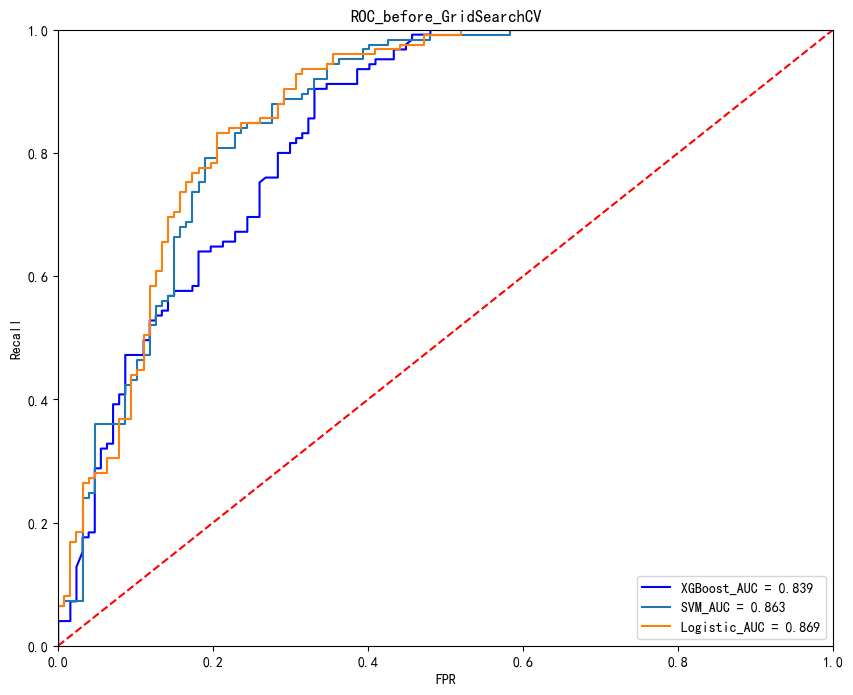

In [18]:
#ROC图的绘制
plt.figure(figsize=(10,8))
plt.plot(FPR_xgb, recall_xgb, 'b', label='XGBoost_AUC = %0.3f' % area_xgb)
plt.plot(FPR_svm, recall_svm,label='SVM_AUC = %0.3f' % area_svm)
plt.plot(FPR_log, recall_log,label='Logistic_AUC = %0.3f' % area_log)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('FPR')
plt.title('ROC_before_GridSearchCV')
plt.savefig('ROC_before_GridSearchCV.jpg')
plt.show()

## 4.3 模型参数调优
**Logistic模型调优：**<br>
**C**：C为正则化系数λ的倒数，必须为正数，默认为1。和SVM中的C一样，值越小，代表正则化越强。
    
**SVM模型调优：**<br> 
**C**：惩罚系数，即对误差的宽容度。c越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。C过大或过小，泛化能力变差<br> 
**gamma**：选择RBF函数作为kernel后，该函数自带的一个参数。隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度。

**XGBoost参数调优：**<br> 
XGBoost的参数较多，这里对三个参数进行了调整，共分为两步调整。整体思路是先调整较为重要的一组参数，然后将调到最优的参数输入模型后继续调下一组参数。详细的参数解释和调参步骤可以戳这里：
[XGBoost参数调优完全指南](https://blog.csdn.net/u010657489/article/details/51952785?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-2-51952785-blog-80142730.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-2-51952785-blog-80142730.pc_relevant_default&utm_relevant_index=5)

In [19]:
parameters_Logr = {'C':[0.05,0.1,0.5,1]}
parameters_svm = {'C':[0.05,0.1,1,5,10,20,50,100],'gamma':[0.01,0.05,0.1,0.2,0.3]}

# 网格搜索
grid_search_log = GridSearchCV(model_logistics,parameters_Logr, cv=5,scoring='roc_auc')
grid_search_log.fit(train_X, train_y)

grid_search_svm = GridSearchCV(model_svm,parameters_svm, cv=5,scoring='roc_auc')
grid_search_svm.fit(X_train_minmax, train_y)

# 获得参数的最优值
print('Log:\n')
print(grid_search_log.best_params_,grid_search_log.best_score_)
print('\nSVM:\n')
print(grid_search_svm.best_params_,grid_search_svm.best_score_)

Log:

{'C': 0.1} 0.8653954169493965

SVM:

{'C': 100, 'gamma': 0.2} 0.8694612133222297


In [20]:
#XGBoost调参
#第一步：先调max_depth、min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(), 
                        param_grid = param_test1,scoring='roc_auc')
gsearch1.fit(train_X,train_y,early_stopping_rounds=500, eval_metric="logloss", eval_set=eval_set, verbose=False)
gsearch1.best_params_,gsearch1.best_score_

({'max_depth': 7, 'min_child_weight': 5}, 0.8799443536281949)

In [21]:
#第二步：调gamma
param_test2 = {
 'gamma':[0.01,0.05,0.1,0.2,0.3,0.5,1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth=3,min_child_weight=3), 
                        param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(train_X,train_y,early_stopping_rounds=500, eval_metric="logloss", eval_set=eval_set, verbose=False)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.3}, 0.8734631256040137)

## 4.4 将调参过后的模型重新进行训练并与原模型比较

In [22]:
model_logistics_after = LogisticRegression(C=0.5)
model_logistics_after.fit(train_X,train_y)
y_pred_after = model_logistics_after.predict(val_X)
scores_logistics_after=[]
scores_logistics_after.append(precision_score(val_y, y_pred_after))
scores_logistics_after.append(recall_score(val_y, y_pred_after))
confusion_matrix_logistics_after=confusion_matrix(val_y,y_pred_after)
f1_score_logistics_after=f1_score(val_y, y_pred_after,labels=None, pos_label=1, average='binary', sample_weight=None)
precision_logistics_after = precision_score(val_y, y_pred_after, average='binary')# 精确率指模型预测为正的样本中实际也为正的样本占被预测为正的样本的比例。
importance_after=pd.DataFrame({"columns":list(val_X.columns), "coef":list(model_logistics_after.coef_.T)})
predictions_log_after=model_logistics_after.predict_proba(val_X)#每一类的概率
FPR_log_after, recall_log_after, thresholds_after = roc_curve(val_y, predictions_log_after[:,1],pos_label=1)
area_log_after=auc(FPR_log_after,recall_log_after)

print('调参后logistics模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_logistics_after))#混淆矩阵
print("f1值:"+str(f1_score_logistics_after))
print("准确率和召回率为："+str(scores_logistics_after))
print('模型系数：\n'+str(importance_after))

调参后logistics模型结果：

       预测值=1  预测值=0
真实值=1    101     26
真实值=0     24    101
f1值:0.8015873015873016
准确率和召回率为：[0.7952755905511811, 0.808]
模型系数：
     columns                   coef
0     年龄_cut   [0.7246488848626378]
1  高密度脂蛋白胆固醇  [-1.0321106796877255]
2        舒张压   [0.8434557514363885]
3         脉搏   [0.7442662456185416]
4        尿素氮  [0.10092649999836241]
5     体重检查结果   [0.5299273243936099]
6         性别   [1.2354443569599831]
7       甘油三酯  [0.22013797347756672]


In [23]:
model_svm_after=SVC(C=100,gamma=0.1,probability=True)
model_svm_after.fit(X_train_minmax,train_y)
y_pred_after = model_svm_after.predict(X_test_minmax)
scores_svm_after=[]
scores_svm_after.append(precision_score(val_y, y_pred_after))
scores_svm_after.append(recall_score(val_y, y_pred_after))
confusion_matrix_svm_after=confusion_matrix(val_y,y_pred_after)
f1_score_svm_after=f1_score(val_y, y_pred_after,labels=None, pos_label=1, average='binary', sample_weight=None)
predictions_svm_after=model_svm.predict_proba(X_test_minmax)#每一类的概率
FPR_svm_after, recall_svm_after, thresholds_after = roc_curve(val_y,predictions_svm_after[:,1], pos_label=1)
area_svm_after = auc(FPR_svm_after,recall_svm_after)

print('调参后svm模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_svm_after))#混淆矩阵
print("f1值:"+str(f1_score_svm_after))
print("准确率和召回率为："+str(scores_svm_after))

调参后svm模型结果：

       预测值=1  预测值=0
真实值=1     95     32
真实值=0     18    107
f1值:0.8106060606060607
准确率和召回率为：[0.7697841726618705, 0.856]


In [24]:
model_XGB_after = XGBClassifier(max_depth= 3, min_child_weight= 3,gamma=0.5)
eval_set = [(val_X, val_y)]
model_XGB_after.fit(train_X, train_y, early_stopping_rounds=500, eval_metric="logloss", eval_set=eval_set, verbose=False)
# verbose改为True就能可视化loss
y_pred_after = model_XGB_after.predict(val_X)

scores_XGB_after=[]
scores_XGB_after.append(precision_score(val_y, y_pred_after))
scores_XGB_after.append(recall_score(val_y, y_pred_after))
confusion_matrix_XGB_after=confusion_matrix(val_y,y_pred_after)
f1_score_XGB_after=f1_score(val_y, y_pred_after,labels=None, pos_label=0, average="binary", sample_weight=None)

predictions_xgb_after=model_XGB_after.predict_proba(val_X)#每一类的概率
FPR_xgb_after, recall_xgb_after, thresholds_after = roc_curve(val_y,predictions_xgb_after[:,1], pos_label=1)
area_xgb_after = auc(FPR_xgb_after,recall_xgb_after)

print('调参后xgboost模型结果：\n')
print(pd.DataFrame(columns=['预测值=1','预测值=0'],index=['真实值=1','真实值=0'],data=confusion_matrix_XGB_after))#混淆矩阵
print("f1值:"+str(f1_score_XGB_after))
print("精确度和召回率:"+str(scores_XGB_after))

调参后xgboost模型结果：

       预测值=1  预测值=0
真实值=1     92     35
真实值=0     25    100
f1值:0.7540983606557378
精确度和召回率:[0.7407407407407407, 0.8]


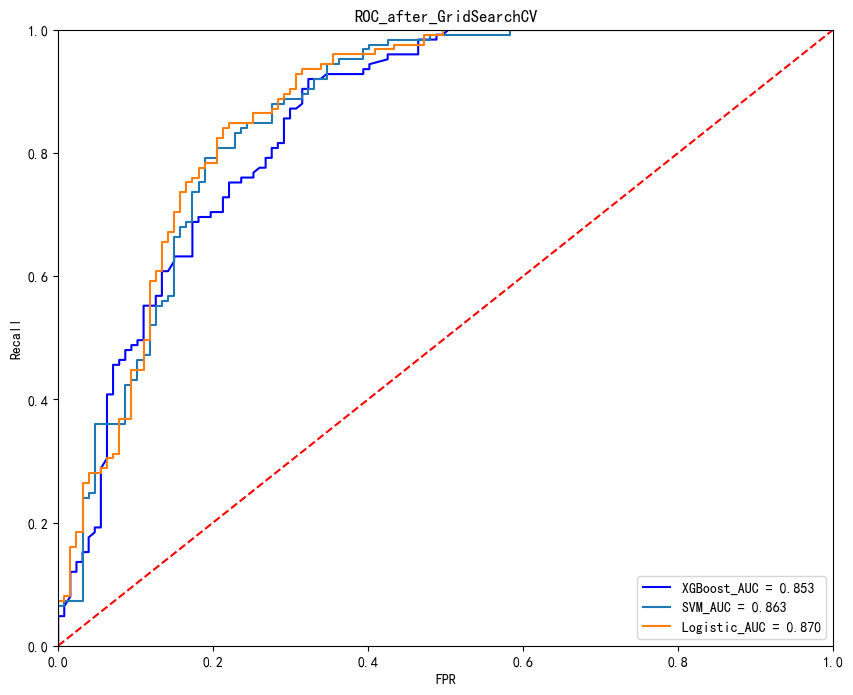

In [26]:
plt.figure(figsize=(10,8))
plt.plot(FPR_xgb_after, recall_xgb_after, 'b', label='XGBoost_AUC = %0.3f' % area_xgb_after)
plt.plot(FPR_svm_after, recall_svm_after,label='SVM_AUC = %0.3f' % area_svm_after)
plt.plot(FPR_log_after, recall_log_after,label='Logistic_AUC = %0.3f' % area_log_after)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('FPR')
plt.title('ROC_after_GridSearchCV')
plt.savefig('ROC_after_GridSearchCV.jpg')
plt.show()

如下表是原模型和调参后的模型的比较（不同随机数种子可能结果有所出入）：

|模型|精确率|精确率_after|召回率|召回率_after|F1-Score|F1-Score_after|AUC|AUC_after|
|::|::|::|::|::|::|::|::|::|
|**Logistic回归**|0.794|0.795|0.8|0.808|0.797|0.802|0.869|0.870|	
|**支持向量机**|0.779|0.770|0.816|0.856|0.797|0.811|0.863|0.863|
|**XGBoost**|0.754|0.752|0.784|0.8|0.763|0.764|0.837|0.855|	

从对比结果可以看出，调参后的模型性能总体略优于调参前的模型。总之，机器学习模型调参是一个需要细致和耐心的工作，不断的努力可能只能带来性能的微小提升==、

# 5 总结
&emsp;&emsp;本项目以体检数据集为样本进行了机器学习的预测，但是需要注意几个问题：

1. 体检数据量太少，仅有1006条可分析数据，这对于糖尿病预测来说是远远不足的，所分析的结果代表性不强。
1. 这里的数据糖尿病和正常人基本相当，而真实的数据具有很强的不平衡性。也就是说，糖尿病患者要远少于正常人，这种不平衡的数据集给真实情况下糖尿病的预测带来了很大困难，当然可以通过上采样、下采样或者其他方法进行不平衡数据集的预测。
1. 缺少时序数据使得预测变得不准确，时序数据更能够体现一个人的身体状态。

&emsp;&emsp;总而言之，机器学习预测疾病道阻且长，尽信机器学习不如无机器学习，经验加技术才是医学预测未来发展的大方向。

**p.s. 欢迎大家点赞和fork(写代码和码字不容易啊谢谢大家)！**